I found 508 files in directory '/home/przemek/Documents/ZrCu_press/Cu/10/xmu'. I am working on ...
OK (I set k, 400 points).
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes does not fit (401 vs 400). Skipped.
Warning, data shapes

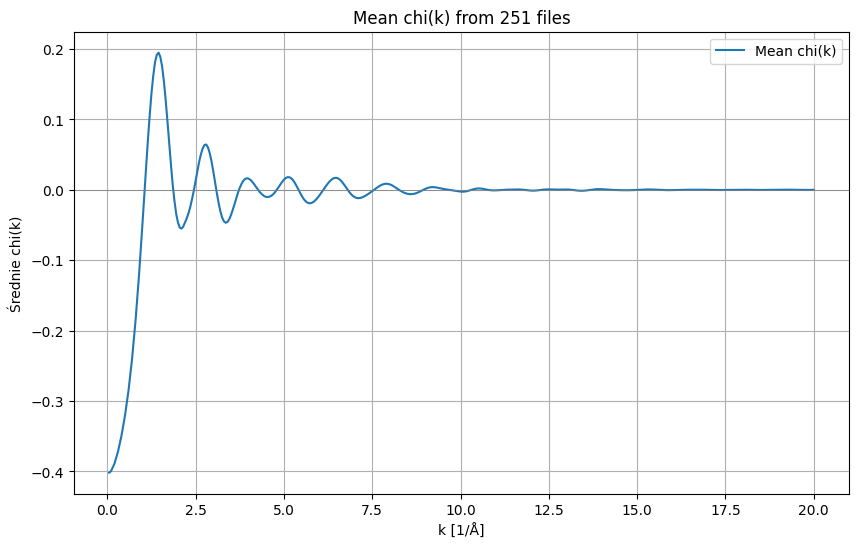

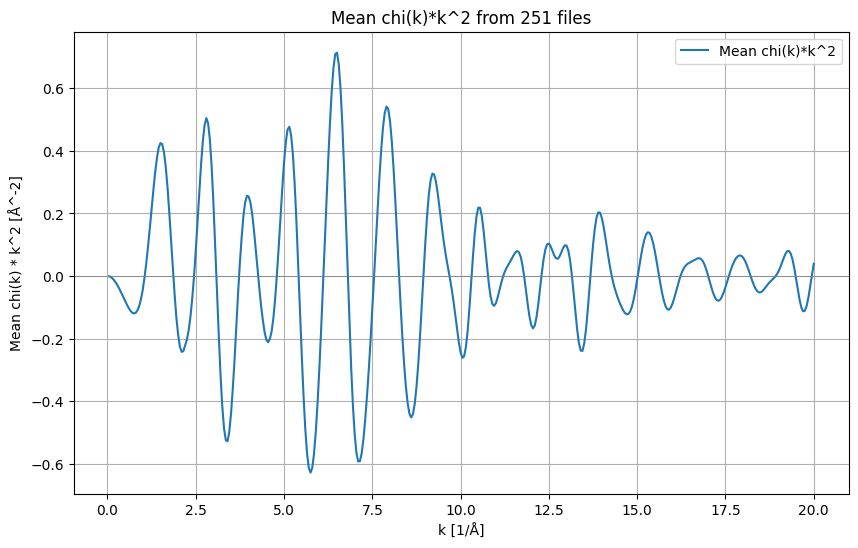


Done! :)


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import numpy as np
import matplotlib.pyplot as plt

"""
The code calculates the mean EXAFS signal based on Molecular Dynamics results.

To use it, you need to prepare FEFF input files (e.g., using the dumpana code from:
https://github.com/lingtikong/dumpana.git) and calculate EXAFS data for at least 500 absorbing atoms.

P. Dziegielewski, pdziegielewski.pl, 2025
"""

def list_files_in_directory(directory_path):
    """ Returns list of files in directory."""
    try:
        all_items = os.listdir(directory_path)
        files = [f for f in all_items if os.path.isfile(os.path.join(directory_path, f))]
        if not files:
            print(f"Warning: Directory '{directory_path}' is empty or return only subdirectories.")
        return np.array(files)
    except FileNotFoundError:
        print(f"Error: Path '{directory_path}' does not exist.")
        return None
    except PermissionError:
        print(f"Error: You have no permission for '{directory_path}'.")
        return None
    except Exception as e:
        print(f"Error: Unexpected error during listing '{directory_path}': {e}")
        return None

def read_exafs_data(file_path):
    """
    Read column k (index 2) and chi (index 5) from the FEFF xmu.dat file.
    Return array [k, chi] or none in the case of error.
    """
    try:
        data = np.genfromtxt(file_path, comments='#', delimiter=None, usecols=(2, 5), dtype=float)

        if data.ndim == 1 and data.size == 2:
             data = data.reshape(1, 2)

        if data.ndim != 2 or data.shape[1] != 2:
             print(f"Warning, unexpected shape of data {data.shape} in file '{os.path.basename(file_path)}'. Skipped.")
             return None
        if data.shape[0] == 0:
             print(f"Warning, there is no data in '{os.path.basename(file_path)}'. Skipped.")
             return None

        return data # return [:,0] = k, [:,1] = chi
    except FileNotFoundError:
        print(f"Error, there is no file in '{file_path}'.")
        return None
    except PermissionError:
        print(f"Error, there is no permission to files in '{file_path}'.")
        return None
    except ValueError as e:
        print(f"Error: wrong data format '{os.path.basename(file_path)}': {e}. Skipped.")
        return None
    except Exception as e:
        print(f"Error: Unexpected error '{os.path.basename(file_path)}': {e}. Skipped.")
        return None

# --- Main -------

# Input directories
input_directory = "/home/przemek/Documents/ZrCu_press/Cu/10/xmu" 
# Output data files name
output_file_chi_k = "mean_chi_k.dat"
output_file_chi_k2 = "mean_chi_k2.dat"

# Read files list
file_names = list_files_in_directory(input_directory)

if file_names is None or len(file_names) == 0:
    print(f"No files found in '{input_directory}' or another error. Stopped.")
    exit()

print(f"I found {len(file_names)} files in directory '{input_directory}'. I am working on ...")

# variables
ref_k = None         # Ref k axis from 1st file
chi_sum = None       # sum of chi signals
num_data_points = -1 # number of data points
valid_file_count = 0 # counter correct files

# main loop
for filename in file_names:
    full_path = os.path.join(input_directory, filename)
    #print(f"Working on: {filename} ... ", end="")

    data = read_exafs_data(full_path)

    if data is None:
        print("Something wrong during reading files.")
        continue

    if ref_k is None:
        ref_k = data[:, 0] 
        num_data_points = len(ref_k)
        
        if num_data_points == 0:
            print(f"Warning: '{filename}' is empty.")
            ref_k = None #
            continue
        chi_sum = np.zeros_like(ref_k) 
        print(f"OK (I set k, {num_data_points} points).")
        
        chi_sum += data[:, 1]
        valid_file_count += 1
    else:
        
        if data.shape[0] == num_data_points:
            
            if not np.allclose(data[:, 0], ref_k, rtol=1e-5, atol=1e-8):
                print(f"Warning: incorect k axis in file '{filename}'. Skipped.")
                continue 
            
            chi_sum += data[:, 1]
            valid_file_count += 1
        else:
            print(f"Warning, data shapes does not fit ({data.shape[0]} vs {num_data_points}). Skipped.")
            continue


if valid_file_count > 0:
    print(f"\nCalculating mean value from {valid_file_count} correct files.")
    chi_avg = chi_sum / valid_file_count
    chi_k2_avg = chi_avg * (ref_k**2)

    # --- Saving files ---
    try:
        # 1. chi(k)
        header_chi_k = f"Mean chi(k) from {valid_file_count} files in {input_directory}\nColumn 1: k [1/Angstrom]\nColmnt 2: mean chi(k)"
        output_data_chi_k = np.column_stack((ref_k, chi_avg))
        np.savetxt(output_file_chi_k, output_data_chi_k, header=header_chi_k, fmt='%.8e', delimiter='   ')
        print(f"Mean chi(k) was written to file: '{output_file_chi_k}'")

        # 2. Zapis chi(k)*k^2
        header_chi_k2 = f"Mean chi(k)*k^2 from {valid_file_count} files in {input_directory}\nColumn 1: k [1/Angstrom]\nColumn 2: mean chi(k)*k^2 [1/Angstrom^2]"
        output_data_chi_k2 = np.column_stack((ref_k, chi_k2_avg))
        np.savetxt(output_file_chi_k2, output_data_chi_k2, header=header_chi_k2, fmt='%.8e', delimiter='   ')
        print(f"Mean chi(k)*k^2 was written to file: '{output_file_chi_k2}'")

    except Exception as e:
        print(f"Error: I cannot write output files: {e}")

    # --- Plots ---
    try:
        # Plot 1: chi(k) vs k
        plt.figure(figsize=(10, 6))
        plt.plot(ref_k, chi_avg, label='Mean chi(k)')
        plt.xlabel("k [1/Å]") 
        plt.ylabel("Średnie chi(k)")
        plt.title(f"Mean chi(k) from {valid_file_count} files")
        plt.grid(True)
        plt.axhline(0, color='grey', linewidth=0.5) 
        plt.legend()

        # Plot 2: chi(k)*k^2 vs k
        plt.figure(figsize=(10, 6))
        plt.plot(ref_k, chi_k2_avg, label='Mean chi(k)*k^2')
        plt.xlabel("k [1/Å]") 
        plt.ylabel("Mean chi(k) * k^2 [Å^-2]") 
        plt.title(f"Mean chi(k)*k^2 from {valid_file_count} files")
        plt.grid(True)
        plt.axhline(0, color='grey', linewidth=0.5) 
        plt.legend()

        print("\nPlotting...")
        plt.show() 

    except Exception as e:
        print(f"Error during plotting {e}")

else:
    print("\nThere were not any correct files. Something is wrong.")

print("\nDone! :)")